<a href="https://colab.research.google.com/github/mtenkoppel/assignment-deep-learning/blob/main/Shortcut_learning_Toy_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook is created for course Deep Learning (DLMDSDL01). It is written in January 2021.

In this notebook I build upon the toy example that demonstrates shortcut learning (Geirhos et al. 2020). 

The goal is to demonstrate how inductive biases lead to shortcut learning. In other words, how interactions between architecture, training data, loss function and learning optimisation lead to a model making predictions that are not intended


# Importing libraries

Fast.ai is a deep learning library that builds on top of PyTorch. The relationship is similar like tensorflow and keras (before the integration)

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.2MB/s 
     |████████████████████████████████| 1.2MB 23.7MB/s 
     |████████████████████████████████| 194kB 47.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
Mounted at /content/gdrive


In [2]:
# a "star-import" is safe and a common practise when using fast.ai
from fastai.vision.all import *

In [14]:
pip install antialiased-cnns

In [4]:
import antialiased_cnns

# Reading data and preparing data

In the original paper numpy is used to create data representation of two classes of 1 channel images. I chose to first render these images to .jpg and process them. I have choosen this approach to try out different image augmentation strategies that would otherwise be to cumbersome to implement.

I chose to be faithful to the dataset the author provides. In total 8000 images were created and used for training+validation.

In [3]:
# Within data.zip all the training and validation data is contained
path = file_extract(fname="data_ood.zip", dest="")
path = (Path() / "data_ood")
path.ls()

(#3) [Path('data_ood/train'),Path('data_ood/.DS_Store'),Path('data_ood/validation')]

In [6]:
# The datablock serves as a "template" from which the data is processed.
# Observe how the independent and dependent variable receive a semantic. 
# The purpose of this is making the loading of the data easier

dblock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
)
dls = dblock.dataloaders(path, bs=100)

In [7]:
# This loads a single batch. X are the independent and y the dependent.
xb, yb = dls.one_batch()

In [8]:
# As expected that shape is (batchsize, channel, heigth, width)
# Note that this is PyTorch convention and deviates from Tensorflow
# Also note that I am loading the images with 3 channels. This is helpful when performing
# the augmentation stategies.
xb.shape

(100, 3, 200, 200)

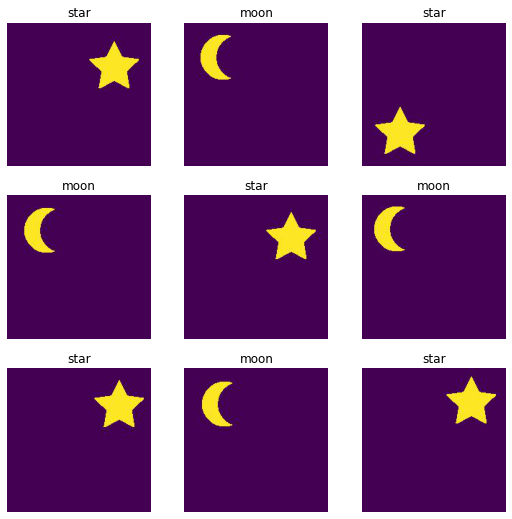

In [9]:
# Moon is always in top left or bottom right
# Star is always in bottom right or top right quadrant
dls.show_batch(nrows=3, ncols=3)

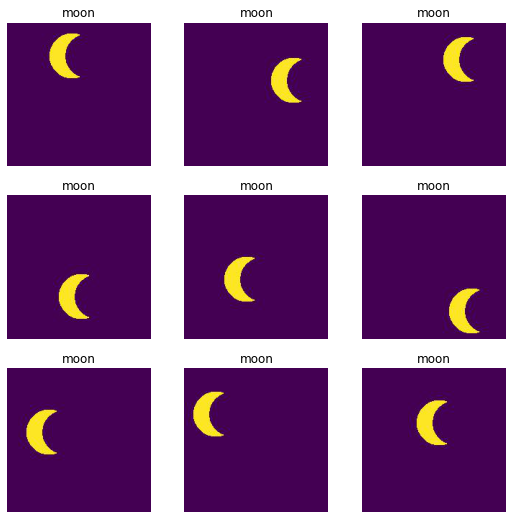

In [10]:
# Here is a batch of out of domain validation images. Observe that the star is no longer pinned to a fixed quadrant. 
dls.valid.show_batch(nrows=3, ncols=3)

# Loading the custom out-of-domain data

In [4]:
# I noticed that when the compression noise was missing, some of the models performed worse.
# To test this hypothesis, I created two types of out-of-domain datasets.
# Bitmap: uses the original shape + noise and with transformations
# Vector: uses a vector to redraw the original shape and applies the identical transformations as bitmap
# Note: the redrawing of the shape is very accurate
path_ood_bmp = file_extract(fname="bitmap_based.zip", dest="")
path_ood_bmp = (Path() / "bitmap_based")
path_ood_bmp.ls()

(#9) [Path('bitmap_based/rotation'),Path('bitmap_based/other'),Path('bitmap_based/pos_size'),Path('bitmap_based/background_shape'),Path('bitmap_based/confirm'),Path('bitmap_based/position'),Path('bitmap_based/background'),Path('bitmap_based/pos_size_transform_rotation'),Path('bitmap_based/transformation')]

In [5]:
path_ood_vector = file_extract(fname="vector_based.zip", dest="")
path_ood_vector = (Path() / "vector_based")
path_ood_vector.ls()

(#9) [Path('vector_based/rotation'),Path('vector_based/other'),Path('vector_based/pos_size'),Path('vector_based/background_shape'),Path('vector_based/confirm'),Path('vector_based/position'),Path('vector_based/background'),Path('vector_based/pos_size_transform_rotation'),Path('vector_based/transformation')]

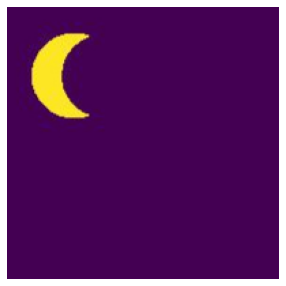

In [13]:
# Bitmap:
# Observe in this image how the edges are jerky and there are artefacts around the "shape". 
# This is similar to the train + validation set.
# The noise is not around the author's dataset. It creeped in after the dataset is rendered to .jpg
# It is a compression artefact. 
im_bmp = Image.open(path_ood_bmp / "confirm" / "moon" / "img-1.jpg")
ax = show_image(im_bmp)


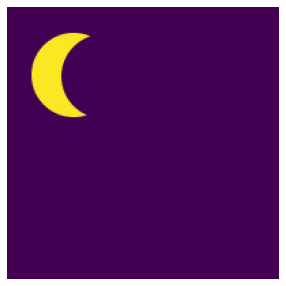

In [14]:
# Vector:
# The shape is smooth and no noise
im_vector = Image.open(path_ood_vector / "confirm" / "moon" / "img-1.jpg")
ax = show_image(im_vector)

# Repeat original experiment

*   Using i.i.d. data (Independent and identical distributed) as validation, causes high accuracy (1.0)
* Using o.o.d. data (Out of Distribution) where the images are positioned freely, causes accuracy to degrade to a mere random decision.




In [23]:
# biased data
path_iid = file_extract(fname="data_iid.zip", dest="")
path_iid = (Path() / "data_iid")
path_iid.ls()


# validation contains out-of-domain data
dblock_1channel = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
)
dls_1channel_iid = dblock_1channel.dataloaders(path_iid, bs=100)
dls_1channel_ood = dblock_1channel.dataloaders(path, bs=100)

def get_feedforward_model():
  return nn.Sequential(
      ConvLayer(3,1),
      Flatten(),
      nn.Linear(200*200,1024),
      nn.ReLU(),
      nn.Linear(1024,1024),
      nn.ReLU(),
      nn.Linear(1024,2),
)

def get_feedforward(dls):
  learn = Learner(dls, get_feedforward_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy, opt_func=Adam)
  return learn

In [24]:
feedforward_iid = get_feedforward(dls_1channel_iid)
feedforward_iid.fit(5, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.016919,0.000000,1.000000,00:06
1,0.005972,0.000000,1.000000,00:06
2,0.002732,0.000000,1.000000,00:06
3,0.001369,0.000000,1.000000,00:06
4,0.000715,0.000000,1.000000,00:06


In [25]:
feedforward_ood = get_feedforward(dls_1channel_ood)
feedforward_ood.fit(5, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.011281,62.431587,0.498500,00:12
1,0.003478,84.009727,0.498750,00:12
2,0.001363,84.489899,0.498750,00:12
3,0.000576,84.321327,0.498750,00:12
4,0.000251,84.291687,0.498750,00:12


# Accuracy calculation for custum ood test set

In [6]:
import statistics
import re 


def find_directory_name(path):
  # searches for everything after last /
  regex = "([^/]+$)"
  m = re.search(regex, path)
  return m.group(0)

def iterate_over_ood_set(ood_set, learner, other=False, verbose=False, multi=False):
  skip_directories = ["other","background"]
  all_accuracies = []
  for path in ood_set.ls():

    if other==True:
      accuracy, result = predict_from_folder(path, learner, verbose,multi)
      all_accuracies.append(accuracy)
    else:
      dir = find_directory_name(str(path))
      if((dir in skip_directories)==False):
        accuracy, result = predict_from_folder(path, learner, verbose,multi)
        all_accuracies.append(accuracy)
    
        if verbose:
          print(f"{str(path)} -> Accuracy: {accuracy}")
  
  overall_accuracy = statistics.mean(all_accuracies)
  
  if verbose:
    print(f"{str(ood_set)} -> Overal accuracy: {overall_accuracy}")
  
  return overall_accuracy

def predict_from_folder(folder, learner, verbose=False, multi=False):
  images = get_image_files(folder)
  result = []
  correct = 0
  for image in images:
    # open up an image
    img_path = image
    im = load_image(img_path)
    im = PILImage(im)

    #make a predition. Label will contain either moon or star
    label, _ , prob = learner.predict(im)
    if multi:
      if(len(label)>0):
        label = label[0]
      else:
        label = "none"
    # check if the predicted label matches. If so add one to correct    
    if(label in str(img_path)):
      correct += 1
      #if verbose:
      #  print(f'correct!:{str(img_path)} is predicted as {label}')
    #else:
      #if verbose:
      #  print(f'mismatch!:{str(img_path)} is predicted as {label}')
    
    # append results
    result.append(f"{image}: {label} with prob {prob.max()}")

  result.sort()
  return (correct/len(result), result)



# Global variables


---



In [7]:
loss_func = CrossEntropyLossFlat()
opt_func = Adam

# Models

## Convolution no pooling

1.   Accuracy o.o.d: 0.53
2.   Accuracy custom o.o.d: 0.65

A convolution is by default not invariant against transformations. This behaviour comes from esspecially max pooling (Goodfellow et al., 2016). In this model, I have removed all pooling layers in favour of convolutional layers with stride 2. This does mean that there is subsampling involved. The final convolutional layer is 2x2.

**Interesting:** The test indicate that there is no position invariance. However, looking at my own custom set, there is in fact invariance against rotation and transformation if the position is correct. It turns out, this is also known as an effective strategy against invariances (Springenberg et al., 2015) found via (Soni,2019)



In [21]:
# Fully connected CNN
def get_conv_model():
  return nn.Sequential(
      ConvLayer(3, 16, ks=3, stride=2, padding=1, norm_type=None), #100x100
      ConvLayer(16, 32, ks=3, stride=2, padding=1, norm_type=None), #50x50
      ConvLayer(32, 64, ks=3, stride=2, padding=1, norm_type=None), #25x25
      ConvLayer(64, 128, ks=3, stride=2, padding=1, norm_type=None), #13x13
      ConvLayer(128, 256, ks=3, stride=2, padding=1, norm_type=None), #7x7
      ConvLayer(256, 512, ks=3, stride=2, padding=1, norm_type=None), #4x4
      ConvLayer(512, 2, ks=3, stride=2, padding=1, norm_type=None), #2x2
      Flatten(),
  )

def get_conv():
  learn = Learner(dls, get_conv_model(), loss_func=loss_func, metrics=accuracy, opt_func=opt_func)
  return learn

In [22]:
conv = get_conv()
conv.fit(2,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.155556,8.559395,0.523500,01:25
1,0.048197,13.490396,0.528750,01:58


In [23]:
accuracy_conv_bmp = iterate_over_ood_set(path_ood_bmp, conv, other=False, verbose=True)
accuracy_conv_vector = iterate_over_ood_set(path_ood_vector, conv, other=False, verbose=True)
accuracy_conv_bmp, accuracy_conv_vector

bitmap_based/transformation -> Accuracy: 0.96875


bitmap_based/pos_size -> Accuracy: 0.3125


bitmap_based/position -> Accuracy: 0.21875


bitmap_based/confirm -> Accuracy: 1.0


bitmap_based/rotation -> Accuracy: 1.0


bitmap_based/background_shape -> Accuracy: 0.5


bitmap_based/pos_size_transform_rotation -> Accuracy: 0.5625
bitmap_based -> Overal accuracy: 0.6517857142857143


vector_based/transformation -> Accuracy: 0.96875


vector_based/pos_size -> Accuracy: 0.3125


vector_based/position -> Accuracy: 0.21875


vector_based/confirm -> Accuracy: 1.0


vector_based/rotation -> Accuracy: 1.0


vector_based/background_shape -> Accuracy: 0.5


vector_based/pos_size_transform_rotation -> Accuracy: 0.59375
vector_based -> Overal accuracy: 0.65625


(0.6517857142857143, 0.65625)

## Convolution max pooling

1.   Accuracy o.o.d: 0.47
2.   Accuracy custom o.o.d: 0.63

Maximum pooling layers help to become invariant against small transformations. However, this is only against small invariances. In this model, I have used 3 convolutional layers. In the last pooling layer images are 25x25. A star or moon in the orginal image is around 70 pixels wide. Still the transformation from the biased to the unbiased validation data is too big.

I was quite surprised by this and tested a similar architecture against the MNIST dataset. The accuracy is 0.98.

**Interesting**: in my custom o.o.d dataset I have images that are aligned in position but are transformed or rotated only. The accuracy on these images is 100%



In [17]:
# max pooling
def get_conv_max_pool_model():
  return nn.Sequential(
      ConvLayer(3, 16, ks=3, stride=1, padding=1, norm_type=None),
      MaxPool(ks=2), #100x100
      ConvLayer(16, 32, ks=3, stride=1, padding=1, norm_type=None),
      MaxPool(ks=2), #50 x 50
      ConvLayer(32, 64, ks=3, stride=1, padding=1, norm_type=None),
      MaxPool(ks=2), #25X25
      
      Flatten(),
      nn.Linear(25*25*64,2)
  )

def get_conv_max_pool():
  learn = Learner(dls, get_conv_max_pool_model(), loss_func=loss_func, metrics=accuracy, opt_func=opt_func)
  return learn

In [27]:
conv_max_pool = get_conv_max_pool()
#conv_max_pool.summary()

conv_max_pool.fit(2, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.064942,5.836578,0.500250,02:48
1,0.020021,6.021021,0.498750,02:47
2,0.007845,6.020335,0.498750,02:45


In [20]:
accuracy_convmaxpool_bmp = iterate_over_ood_set(path_ood_bmp, conv_max_pool, other=False, verbose=True)
accuracy_convmaxpool_vector = iterate_over_ood_set(path_ood_vector, conv_max_pool, other=False, verbose=True)
accuracy_convmaxpool_bmp, accuracy_convmaxpool_vector

bitmap_based/transformation -> Accuracy: 0.984375


bitmap_based/pos_size -> Accuracy: 0.28125


bitmap_based/position -> Accuracy: 0.25


bitmap_based/confirm -> Accuracy: 1.0


bitmap_based/rotation -> Accuracy: 0.875


bitmap_based/background_shape -> Accuracy: 0.5


bitmap_based/pos_size_transform_rotation -> Accuracy: 0.53125
bitmap_based -> Overal accuracy: 0.6316964285714286


vector_based/transformation -> Accuracy: 0.984375


vector_based/pos_size -> Accuracy: 0.28125


vector_based/position -> Accuracy: 0.25


vector_based/confirm -> Accuracy: 1.0


vector_based/rotation -> Accuracy: 0.875


vector_based/background_shape -> Accuracy: 0.5


vector_based/pos_size_transform_rotation -> Accuracy: 0.46875
vector_based -> Overal accuracy: 0.6227678571428571


(0.6316964285714286, 0.6227678571428571)

## Convolution no max pooling but average pooling

1.   Accuracy o.o.d: 1.0
2.   Accuracy custom o.o.d: 0.75

When I did the first experiments, I used a resnet model to get a baseline. I noticed that the o.o.d accuracy was 1. I wondered what the reason for this is. 

Resnet-18 has an average pooling after the convolutional layers and before a feedforward net starts. I made a simple model with 3 non-subsampling convolutions and average pooling. As you can see the accuracy is 1.0

Keep in mind that this is not like max or avg pooling layers. What this does is, is take every convolutional image and take an average (Howard & Gugger, 2020). In this model there are in the final convolutional layer 64 images outputted (each of 200x200). The result is 64 "averages". Those are flattened.

I googled it and found via (User8879803, nd) a paper describing the effect of the averagepooling layer (Lin et al., 2014). The authors describe that:
"Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer. One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps. Another advantage is that there is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. **Futhermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input.**
" (p. 4)


In [28]:
# Fully connected CNN
def get_conv_adaptiveavgpool_model():
  return nn.Sequential(
      ConvLayer(3, 16, ks=3, stride=1, padding=1, norm_type=None),
      ConvLayer(16, 32, ks=3, stride=1, padding=1, norm_type=None),
      ConvLayer(32, 64, ks=3, stride=1, padding=1, norm_type=None),
      AdaptiveAvgPool(1),   
      Flatten(),
      nn.Linear(64,2)
  )

def get_conv_adaptiveavgpool():
  learn = Learner(dls, get_conv_adaptiveavgpool_model(), loss_func=loss_func, metrics=accuracy, opt_func=opt_func)
  return learn

In [29]:
conv_adaptiveavgpool = get_conv_adaptiveavgpool()
conv_adaptiveavgpool.fit(2, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.666265,0.604097,1.000000,13:09
1,0.463205,0.162978,1.000000,13:16


In [30]:
accuracy_conv_adaptiveavgpool_bmp = iterate_over_ood_set(path_ood_bmp, conv_adaptiveavgpool, other=False, verbose=True)
accuracy_conv_adaptiveavgpool_vector = iterate_over_ood_set(path_ood_vector, conv_adaptiveavgpool, other=False, verbose=True)
accuracy_conv_adaptiveavgpool_bmp, accuracy_conv_adaptiveavgpool_vector

bitmap_based/transformation -> Accuracy: 0.75


bitmap_based/pos_size -> Accuracy: 0.5


bitmap_based/position -> Accuracy: 1.0


bitmap_based/confirm -> Accuracy: 1.0


bitmap_based/rotation -> Accuracy: 1.0


bitmap_based/background_shape -> Accuracy: 0.5


bitmap_based/pos_size_transform_rotation -> Accuracy: 0.5
bitmap_based -> Overal accuracy: 0.75


vector_based/transformation -> Accuracy: 0.75


vector_based/pos_size -> Accuracy: 0.5


vector_based/position -> Accuracy: 1.0


vector_based/confirm -> Accuracy: 1.0


vector_based/rotation -> Accuracy: 1.0


vector_based/background_shape -> Accuracy: 0.5


vector_based/pos_size_transform_rotation -> Accuracy: 0.5
vector_based -> Overal accuracy: 0.75


(0.75, 0.75)

## Resnet 18

1.   Accuracy o.o.d:
2.   Accuracy custom o.o.d:

My hypothesis would be that a deeper neural net would find better "abstractions" of shape and be better able to generalize. This is tested with a resnet-18. The model is provided by fast.ai 

In [31]:
# Resnet 18 without pretraining
def get_resnet_model():
  return resnet18

def get_resnet():
  learn = cnn_learner(dls,get_resnet_model(),loss_func=loss_func, metrics=accuracy, opt_func=opt_func, pretrained=False, normalize=False)
  return learn

In [32]:
resnet_learn = get_resnet()
resnet_learn.fit(2, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.021579,34.074043,0.500000,20:31
1,0.006653,0.001161,0.999750,20:29


In [33]:
accuracy_resnet_bmp = iterate_over_ood_set(path_ood_bmp, resnet_learn, other=False, verbose=True)
accuracy_resnet_vector = iterate_over_ood_set(path_ood_vector, resnet_learn, other=False, verbose=True)
accuracy_resnet_bmp, accuracy_resnet_vector

bitmap_based/transformation -> Accuracy: 0.75


bitmap_based/pos_size -> Accuracy: 0.625


bitmap_based/position -> Accuracy: 0.5625


bitmap_based/confirm -> Accuracy: 0.5625


bitmap_based/rotation -> Accuracy: 0.5


bitmap_based/background_shape -> Accuracy: 0.5


bitmap_based/pos_size_transform_rotation -> Accuracy: 0.625
bitmap_based -> Overal accuracy: 0.5892857142857143


vector_based/transformation -> Accuracy: 0.734375


vector_based/pos_size -> Accuracy: 0.625


vector_based/position -> Accuracy: 0.5625


vector_based/confirm -> Accuracy: 0.5625


vector_based/rotation -> Accuracy: 0.5


vector_based/background_shape -> Accuracy: 0.5


vector_based/pos_size_transform_rotation -> Accuracy: 0.625
vector_based -> Overal accuracy: 0.5870535714285714


(0.5892857142857143, 0.5870535714285714)

## Antialiased cnn from Zhang


1.   Accuracy o.o.d: 1.0
2.   Accuracy custom o.o.d: 0.8


In the course book the method from (Zhang,2020) is mentioned as way to overcome invariance against translations or rotations.

I looked up the paper and discovered this paper is more about retaining the spatial relationship features have (this is lost with max pooling, which for instance resnet uses as well) Conveniently, the authors provided an implementation for pytorch that operates on a resnet-18. This allows me to compare the results.


In [15]:
# Antialiased CNN from Zhang
import antialiased_cnns

def get_antialiased_model():
  return antialiased_cnns.resnet18(pretrained=False, filter_size=4)

def get_antialiased():
  learn = Learner(dls, get_antialiased_model(), loss_func=loss_func, metrics=accuracy, opt_func=opt_func)
  return learn

In [35]:
antialiased = get_antialiased()
antialiased.fit(2,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.117897,7.098935,0.500250,27:01
1,0.036362,0.000014,1.000000,26:44


In [36]:
accuracy_antialiased_bmp = iterate_over_ood_set(path_ood_bmp, antialiased, other=False, verbose=True)
accuracy_antialiased_vector = iterate_over_ood_set(path_ood_vector, antialiased, other=False, verbose=True)
accuracy_antialiased_bmp, accuracy_antialiased_vector

bitmap_based/transformation -> Accuracy: 0.8125


bitmap_based/pos_size -> Accuracy: 0.625


bitmap_based/position -> Accuracy: 1.0


bitmap_based/confirm -> Accuracy: 1.0


bitmap_based/rotation -> Accuracy: 1.0


bitmap_based/background_shape -> Accuracy: 0.625


bitmap_based/pos_size_transform_rotation -> Accuracy: 0.5
bitmap_based -> Overal accuracy: 0.7946428571428571


vector_based/transformation -> Accuracy: 0.8125


vector_based/pos_size -> Accuracy: 0.625


vector_based/position -> Accuracy: 1.0


vector_based/confirm -> Accuracy: 1.0


vector_based/rotation -> Accuracy: 1.0


vector_based/background_shape -> Accuracy: 0.5


vector_based/pos_size_transform_rotation -> Accuracy: 0.5
vector_based -> Overal accuracy: 0.7767857142857143


(0.7946428571428571, 0.7767857142857143)

# Data augmentation

Based on ResNet-18 with antialiasing layer

1.   Accuracy o.o.d: 1.0
2.   Acuracy custom o.o.d: 0.88 

It turns out that the resnet-18 with antialiasing provided the best intitial results. In a next step, I wanted to find out how data augmentation could help even further.

Fast.ai provides convenient augmentation methods. 

In [8]:
# Fast.ai has a convenient data augmentation 
dblock_aug = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
    batch_tfms=[*aug_transforms(size=200)]
)
dls_aug = dblock_aug.dataloaders(path, bs=100)

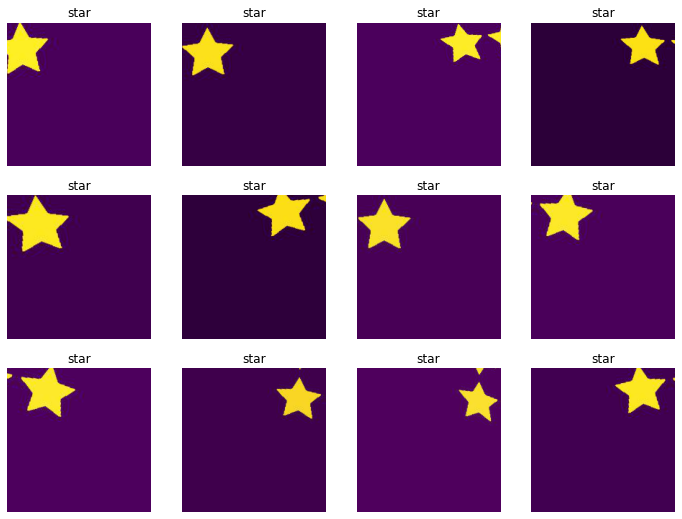

In [11]:
# let's have a look at what this is doing
dls_aug.train.show_batch(max_n=12,nrows=3, unique=True)

This demonstrates that one has to be careful with dataaugmentation. For instance, cropping of an star can lead to triangles.

So this one bullet beats all does not work on this specific dataset. The learning here, is that domain knowledge is required if you want to apply data augmentation.

For this shape example, it might be easy to recognise: but what about if there are cancer images: could we flip, rotate and crop there?

In [34]:
# Fast.ai has a convenient data augmentation 
dblock_aug_specific = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
    batch_tfms=[FlipItem(),Rotate(),Warp()]
)
dls_aug_specific = dblock_aug_specific.dataloaders(path, bs=100)

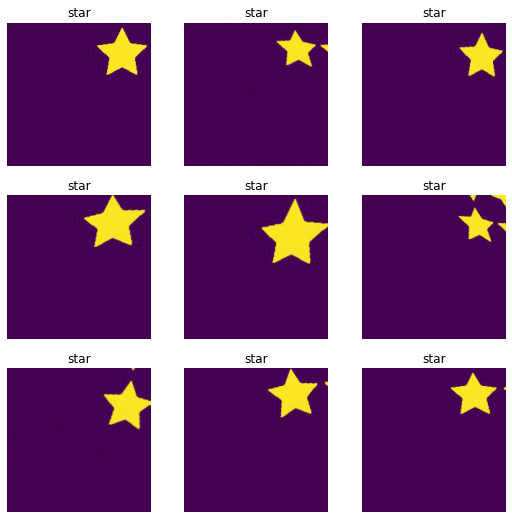

In [35]:
dls_aug_specific.train.show_batch(max_n=9,nrows=3, unique=True)

In [31]:
learn_augment = Learner(dls_aug_specific, get_antialiased_model(), loss_func=loss_func, metrics=accuracy, opt_func=opt_func)

In [32]:
learn_augment.fit(2,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.130352,2.680696,0.571750,00:19
1,0.040355,0.000065,1.000000,00:19


In [33]:
accuracy_augmented_bmp = iterate_over_ood_set(path_ood_bmp, learn_augment, other=False, verbose=True)
accuracy_augmented_vector = iterate_over_ood_set(path_ood_vector, learn_augment, other=False, verbose=True)
accuracy_augmented_bmp, accuracy_augmented_vector

bitmap_based/rotation -> Accuracy: 0.875


bitmap_based/pos_size -> Accuracy: 0.75


bitmap_based/background_shape -> Accuracy: 0.8125


bitmap_based/confirm -> Accuracy: 1.0


bitmap_based/position -> Accuracy: 1.0


bitmap_based/pos_size_transform_rotation -> Accuracy: 0.75


bitmap_based/transformation -> Accuracy: 0.9375
bitmap_based -> Overal accuracy: 0.875


vector_based/rotation -> Accuracy: 0.875


vector_based/pos_size -> Accuracy: 0.75


vector_based/background_shape -> Accuracy: 0.5


vector_based/confirm -> Accuracy: 1.0


vector_based/position -> Accuracy: 1.0


vector_based/pos_size_transform_rotation -> Accuracy: 0.75


vector_based/transformation -> Accuracy: 0.9375
vector_based -> Overal accuracy: 0.8303571428571429


(0.875, 0.8303571428571429)

# Bibliography

Geirhos, R., Jacobsen, J.-H., Michaelis, C., Zemel, R., Brendel, W., Bethge, M., & Wichmann, F. A. (2020). Shortcut Learning in Deep Neural Networks.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

Howard, J., & Gugger, S. (2020). Deep Learning for Coders with Fastai and PyTorch.

Lin, M., Chen, Q., & Yan, S. (2014). Network in network. 2nd International Conference on Learning Representations, ICLR 2014 - Conference Track Proceedings.

Soni, D. (2019). Translation Invariance in Convolutional Neural Networks | by Divyanshu Soni | Medium. https://divsoni2012.medium.com/translation-invariance-in-convolutional-neural-networks-61d9b6fa03df

Springenberg, J. T., Dosovitskiy, A., Brox, T., & Riedmiller, M. (2015, December 21). Striving for simplicity: The all convolutional net. 3rd International Conference on Learning Representations, ICLR 2015 - Workshop Track Proceedings.

User8879803. (n.d.). why does the global average pooling work in ResNet - Stack Overflow. Retrieved January 14, 2021, from https://stackoverflow.com/questions/58689997/why-does-the-global-average-pooling-work-in-resnet

Zhang, R. (2019). Making convolutional networks shift-invariant again. 36th International Conference on Machine Learning, ICML 2019, 2019-June, 12712–12722.



